In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v016.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

Loading ../data/BIOQIC/downloads/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
<xarray.Dataset>
Dimensions:    (frequency: 6, x: 80, y: 100, z: 10, component: 3)
Coordinates:
  * frequency  (frequency) int64 50 60 70 80 90 100
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
  * z          (z) float64 0.0 0.001 0.002 0.003 ... 0.006 0.007 0.008 0.009
  * component  (component) <U1 'y' 'x' 'z'
Data variables:
    wave       (frequency, x, y, z, component) complex128 (0.0018039287661982...
Segmenting spatial regions
Creating ground truth elastogram
Writing ../data/BIOQIC/fem_box/50/wave.nc
Writing ../data/BIOQIC/fem_box/50/mre.nc
Writing ../data/BIOQIC/fem_box/50/mre_mask.nc
Writing ../data/BIOQIC/fem_box/60/wave.nc
Writing ../data/BIOQIC/fem_box/60

In [4]:
%autoreload
dataset = mre_pinn.data.MREDataset.load_xarrays('../data/BIOQIC/fem_box')

Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc


In [5]:
dataset[0].metadata

size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [6]:
dataset[0].describe()

dtype    count                     mean          std  \
variable component                                                              
wave     y          complex128  80000.0  -0.00000100-0.00000500j     0.000191   
         x          complex128  80000.0   0.00003800-0.00004900j     0.000192   
         z          complex128  80000.0  -0.00008600+0.00000600j     0.003931   
mre      scalar     complex128  80000.0  3362.250000+628.318531j  1550.653068   
mre_mask scalar          int64  80000.0   1.06650000+0.00000000j     0.313174   

                                        min                      25%  \
variable component                                                     
wave     y          -0.00030500+0.00004300j  -0.00005200+0.00011100j   
         x          -0.00043400-0.00022700j  -0.00001500+0.00003700j   
         z          -0.00992300+0.00235900j  -0.00131600-0.00074800j   
mre      scalar     3000.000000+628.318531j  3000.000000+628.318531j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                        50%                      75%  \
variable component                                                     
wave     y          -0.00000600+0.00003100j   0.00004600+0.00004500j   
         x           0.00003600+0.00015600j   0.00009700-0.00016000j   
         z          -0.00005800-0.00051100j   0.00109500-0.00054600j   
mre      scalar     3000.000000+628.318531j  3000.000000+628.318531j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                         max  
variable component                            
wave     y          0.000291000-0.000004000j  
         x          0.000466000-0.000245000j  
         z          0.008269000+0.002027000j  
mre      scalar     10000.000000+628.318531j  
mre_mask scalar     5.000000000+0.000000000j

In [7]:
%autoreload
dataset[0].eval_baseline(frequency=dataset[0].wave.frequency.item(), polar=True)

<IPython.core.display.Javascript object>


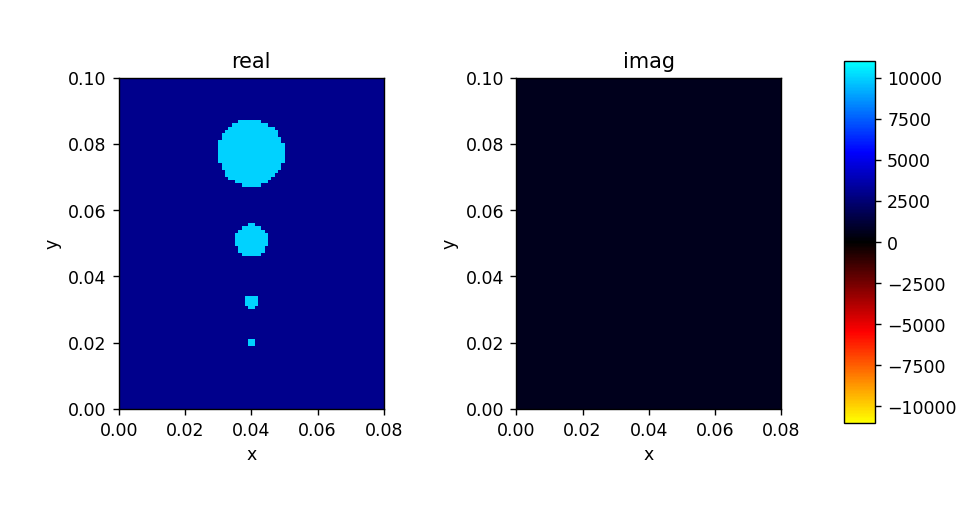

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


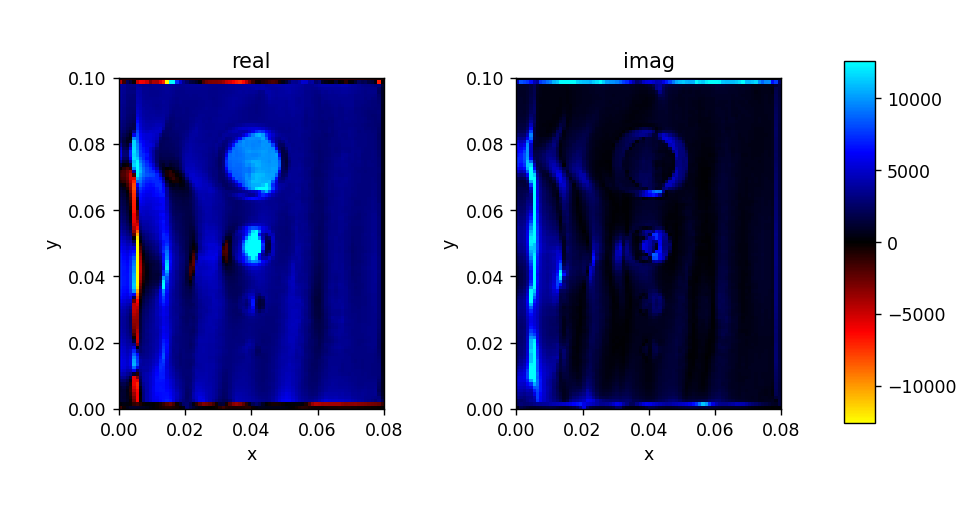

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [8]:
dataset[0].view('mre', 'base', ax_height=3, col='part', polar=False)

In [ ]:
%autoreload

# initialize the PDE, geometry, and boundary conditions
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
geom = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0) + 1e-5)
#geom = deepxde.geometry.PointCloud(x)
bc = mre_pinn.fields.VectorFieldBC(x, u)

In [ ]:
%autoreload

# define model architecture

net = mre_pinn.model.MREPINN(
    input=x,
    outputs=[u, mu],
    omega0=16,
    n_layers=5,
    n_hidden=128,
    activ_fn='t',
    parallel=True,
    dense=True,
    dtype=torch.float32
)

net

In [ ]:
model = mre_pinn.training.MREPINNModel(
    net, pde, geom, bc,
    batch_size=80,
    num_domain=128 - 80,
    num_boundary=0,
    train_distribution='pseudo', # NOT using anchors currently!
    anchors=None
)

In [ ]:
# descriptive statistics

%autoreload

kws = dict(axis=0, keepdims=True)

# standardize input to [-1, 1]
x_loc = x.mean(**kws)
x_scale = (x.max(**kws) - x.min(**kws)) / 2
print('x', x_loc, x_scale)

# avoid division by zero
x_scale[x_scale == 0] = 1
x_s = (x - x_loc) / x_scale

# test forward pass
u_pred, lu_pred, mu_pred, f_trac, f_body = model.predict(x, batch_size=128)
pde_res = f_trac + f_body

u_pred = u_pred.detach().cpu().numpy()
lu_pred = lu_pred.detach().cpu().numpy()
mu_pred = mu_pred.detach().cpu().numpy()

# normalize outputs via mean and std
u_loc = u.mean(**kws)
u_scale = u.std(**kws)
print('u', u_loc, u_scale)

u_s = (u - u_loc) / u_scale
u_pred_s = (u_pred - u_loc) / u_scale

mu_loc = mu.mean(**kws)
mu_scale = mu.std(**kws)
print('mu', mu_loc, mu_scale)

mu_s = (mu - mu_loc) / mu_scale
mu_pred_s = (mu_pred - mu_loc) / mu_scale

# compute laplacian statistics
lu_loc = lu_pred.mean(**kws)
lu_scale = lu_pred.std(**kws)
print('lu', lu_loc, lu_scale)

# display input and output distributions

def hex_to_rgb(h):
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def plot_hist(ax, a, xlabel, hue=None):
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a)
    bin_width = (a.max() - a.min()) / 20
    for a, hue in zip(a.T, hue):
        bins = np.arange(a.min(), a.max() + bin_width, bin_width)
        color = next(ax._get_lines.prop_cycler)["color"]
        ax.hist(a, bins=bins, label=hue, edgecolor='0.2', fc=color + '80')
    ax.set_xlabel(xlabel)
    ax.legend(frameon=True, edgecolor='0.2')

fig, axes = plt.subplots(6, 2, figsize=(8, 10))

ndim = len(data.u.field.spatial_dims)
x_hues = ['$\omega$', '$x$', '$y$', '$z$'][:ndim+1]
plot_hist(axes[0,0], x,   hue=x_hues, xlabel='x')
plot_hist(axes[0,1], x_s, hue=x_hues, xlabel='x_s')

u_hues = ['$u_z$', '$u_y$', '$u_x$'][:ndim]
u_hues = [p.format(h) for h in u_hues for p in ['Re[{}]', 'Im[{}]']]
plot_hist(axes[1,0], u_pred,   hue=u_hues, xlabel='u_pred')
plot_hist(axes[1,1], u_pred_s, hue=u_hues, xlabel='u_pred_s')

plot_hist(axes[2,0], u,   hue=u_hues, xlabel='u_true')
plot_hist(axes[2,1], u_s, hue=u_hues, xlabel='u_true_s')

mu_hues = ['Re[$\mu$]', 'Im[$\mu$]']
plot_hist(axes[3,0], mu_pred,   hue=mu_hues, xlabel='mu_pred')
plot_hist(axes[3,1], mu_pred_s, hue=mu_hues, xlabel='mu_pred_s')

plot_hist(axes[4,0], mu,   hue=mu_hues, xlabel='mu_true')
plot_hist(axes[4,1], mu_s, hue=mu_hues, xlabel='mu_true_s')

lu_hues = ['$\\nabla^2 u_z$', '$\\nabla^2 u_y$', '$\nabla^2 u_x$'][:ndim]
#lu_hues = [p.format(h) for h in lu_hues for p in ['Re[{}]', 'Im[{}]']]
plot_hist(axes[5,0], lu_pred, hue=lu_hues, xlabel='lu_pred')

fig.tight_layout()

In [ ]:
%autoreload

model.compile(
    optimizer='adam',
    lr=1e-4,
    loss_weights=[1e-8, 1],
    loss=mre_pinn.training.normalized_l2_loss_fn(u)
)
deepxde.display.training_display = mre_pinn.training.SummaryDisplay()
callbacks = [
    mre_pinn.training.TestEvaluation(test_data, batch_size=128, test_every=100, save_every=1000, interact=True),
    mre_pinn.training.PDEResampler(period=1),
]

try:
    model.train(100000, display_every=10, callbacks=callbacks)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

In [ ]:
%autoreload
test_eval = mre_pinn.training.TestEvaluation(data, batch_size=128, plot=False, view=True, interact=True)
test_eval.model = model
test_eval.test_evaluate(data)